In [1]:
# !pip install git+https://github.com/jkulhanek/viewformer.git  # Allow viewformer import
# !pip uninstall -y torchtext torchaudio  # Fix for Google Colab
# Hack to fix a bug with COLAB, does not happen locally
import viewformer.models.utils
setattr(viewformer.models.utils, 'load_lpips_model', lambda *args, **kwargs: None)
# End of hack
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

REMOTE_URL = 'https://data.ciirc.cvut.cz/public/projects/2022ViewFormer'
!export REMOTE_URL="https://data.ciirc.cvut.cz/public/projects/2022ViewFormer"

2023-05-06 13:58:02.760950: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-06 13:58:06.540553: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load FEI dataset
from viewformer.data.loaders import DatasetLoader

test_loader = DatasetLoader(path=os.path.expanduser('/scratch/network/tmd4/viewformer/datasets/fei'), split='test')

# Load codebook and transformer models for interiornet
from viewformer.utils.tensorflow import load_model

codebook = load_model(os.path.expanduser('/scratch/network/tmd4/viewformer/models/interiornet-codebook-th/model.ckpt'))
transformer = load_model('interiornet-transformer-tf')

DatasetLoader init
shards ['/scratch/network/tmd4/viewformer/datasets/fei/fei-test-000001-of-000001.tfrecord']


2023-05-06 13:58:16.316669: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-05-06 13:58:16.611720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


Working with z of shape (1, 256, 8, 8) = 16384 dimensions.
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/tmd4/.conda/envs/viewformer/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


/home/tmd4/.conda/envs/viewformer/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


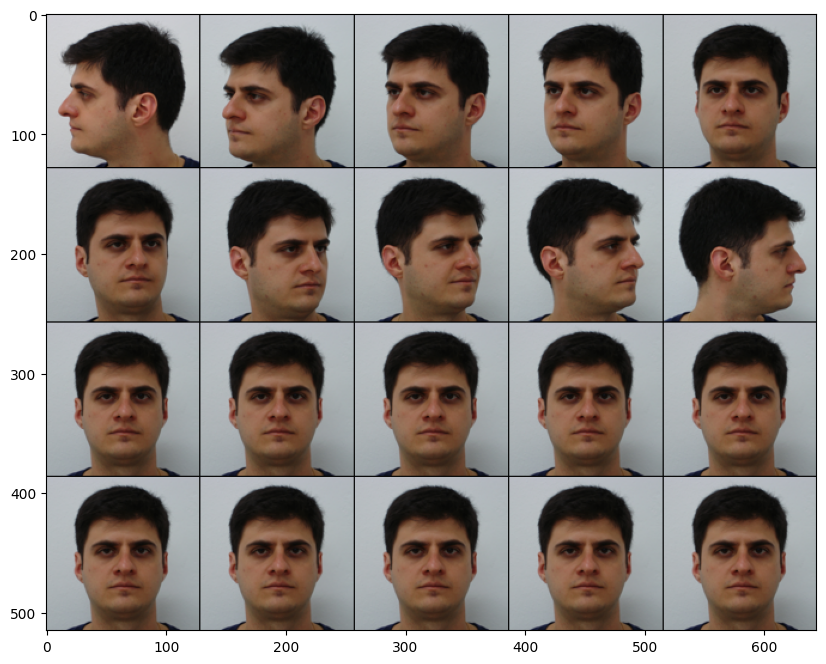

In [3]:
# Show InteriorNet sample
from viewformer.utils.visualization import np_imgrid

input_batch = test_loader[0]['frames'].astype('float32') / 255.
plt.imshow(np_imgrid(input_batch)[0])
plt.show()

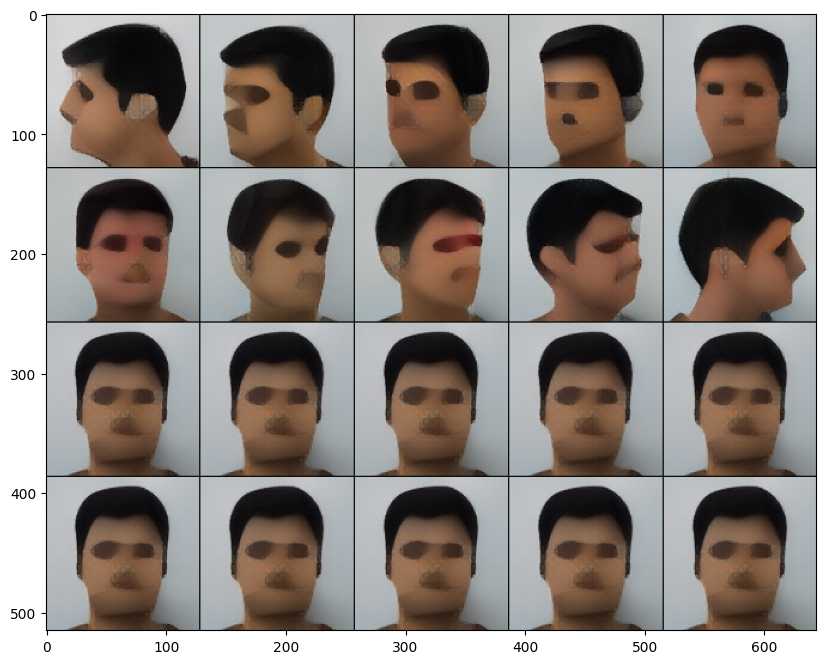

In [4]:
# Show codebook reconstruction
input_batch = test_loader[0]['frames'].astype('float32') / 255.
output_batch = np.clip(codebook(input_batch * 2 - 1)[0] / 2 + 0.5, 0, 1)

plt.imshow(np_imgrid(output_batch)[0])
plt.show()

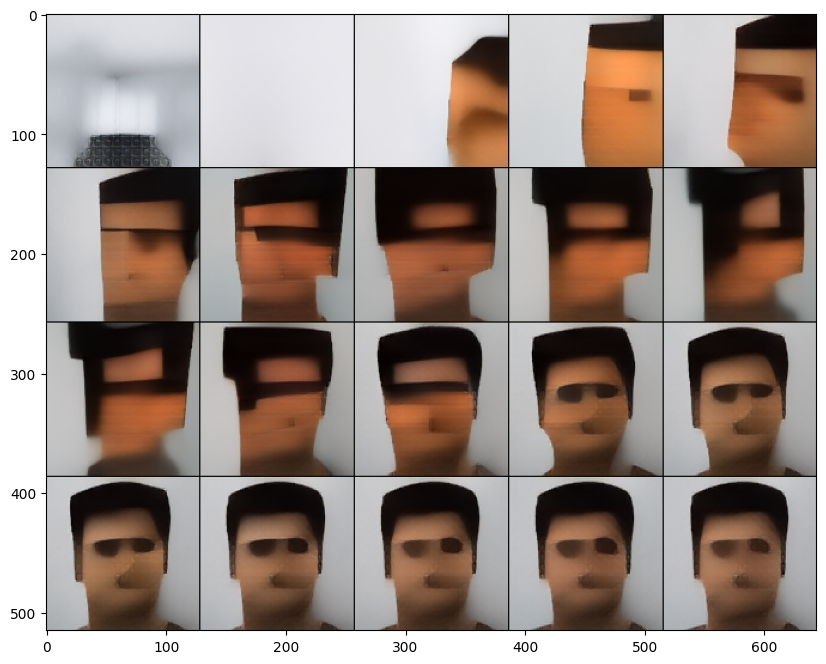

In [5]:
# Evaluate full pipeline with multiple context sizes
# Shows the last view with increasing context size
from viewformer.evaluate.evaluate_transformer_multictx import generate_batch_predictions
images, cameras = test_loader[0]['frames'][np.newaxis, ...], test_loader[0]['cameras'][np.newaxis, ...]
output = generate_batch_predictions(transformer, codebook, images, cameras)
plt.imshow(np_imgrid(output['generated_images'][0])[0])
plt.show()

In [6]:
cameras.shape

(1, 20, 7)

In [7]:
cameras[:, -1:].shape

(1, 1, 7)